In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import scienceplots
plt.style.use(['science','notebook','grid'])
import numba
from numba import njit
import shapely


In [5]:
N = 100

In [7]:
init_random = np.random.random((N,N))
lattice_n = np.zeros((N,N))
lattice_n[init_random>=0.25] = 1
lattice_n[init_random<0.25] = -1

init_random = np.random.random((N,N))
lattice_p = np.zeros((N,N))
lattice_p[init_random>=0.75] = 1
lattice_p[init_random<0.75] = -1

In [9]:
plt.imshow(init_random)

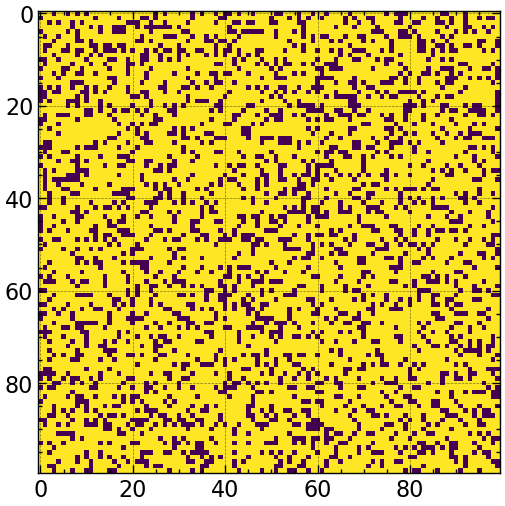

In [11]:
plt.imshow(lattice_n)

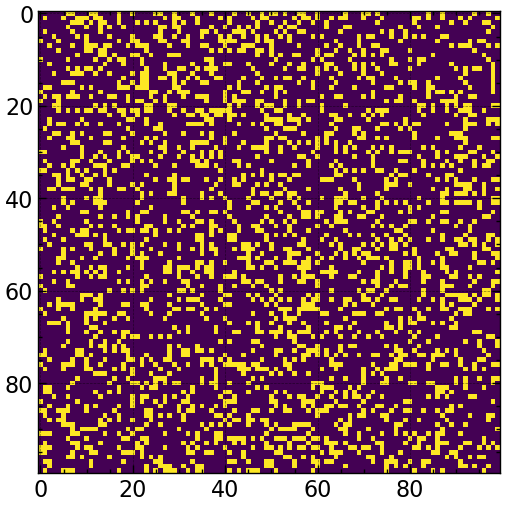

In [13]:
plt.imshow(lattice_p)

In [15]:
window = scipy.ndimage.generate_binary_structure(2,1)
window

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]])

In [17]:
def energy(lattice):
    window = scipy.ndimage.generate_binary_structure(2,1)
    window [1][1] = False
    line = -lattice*scipy.ndimage.convolve(lattice,window,mode ='constant' ,cval =0 )
    return line.sum()

In [19]:
energy(lattice_p)

-9432.0

In [21]:
@numba.njit( "UniTuple(f8[:],2)(f8[:,:],i8,f8,f8)", nopython=True, nogil=True)
def function(spin_arr,times,BJ,energy):
    spin_arr = spin_arr.copy()
    net_spin = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for i in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y]
        spin_f = spin_i*-1
        
        
        E_i =0
        E_f =0
        if x>0:
            if x>0:
                E_i = E_i - spin_i*spin_arr[x-1,y]
                E_f = E_f - spin_f*spin_arr[x-1,y]
        if x< N-1:
            E_i = E_i - spin_i*spin_arr[x+1,y]
            E_f = E_f - spin_f*spin_arr[x+1,y]
        if y>0:
            E_i = E_i - spin_i*spin_arr[x,y-1]
            E_f = E_f - spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i = E_i - spin_i*spin_arr[x,y+1]
            E_f = E_f - spin_f*spin_arr[x,y+1]
            
        dE = E_f -E_i
        if(dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y] = spin_f
            energy = energy + dE
        elif dE<=0 :
            spin_arr[x,y] = spin_f
            energy = energy + dE
        
        
        net_spin[i] = spin_arr.sum()
        net_energy[i] = energy
    
    
    return net_spin , net_energy

C:\Users\Lenovo\anaconda3\Lib\site-packages\numba\core\decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [ ]:
spins, energies = function(lattice_n,1e8,2,energy(lattice_n))

In [57]:
fig , axes = plt.subplots(1,2,figsize = (30,10))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Time')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Time')
ax.set_ylabel(r'Average Spin $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.7' ,y=1.07 , size =18)
plt.show()

In [56]:
def get_spin_energy(lattice,BJs):
    ms =np.zeros(len(BJs))
    E_mean =np.zeros(len(BJs))
    E_std =np.zeros(len(BJs))
    for i , bj in enumerate(BJs):
       spins, energies = function(lattice,100000,bj,energy(lattice)) 
       ms[i] = spins[-1000:].mean()/N**2
       E_mean[i] = energies[-1000:].mean()
       E_std[i] = energies[-1000:].std()
    return ms,E_mean,E_std
BJs = np.arange(0.1,2,0.05)
ms_n, E_mean_n ,E_std_n =get_spin_energy(lattice_n,BJs)
ms_p, E_mean_p ,E_std_p =get_spin_energy(lattice_p,BJs)

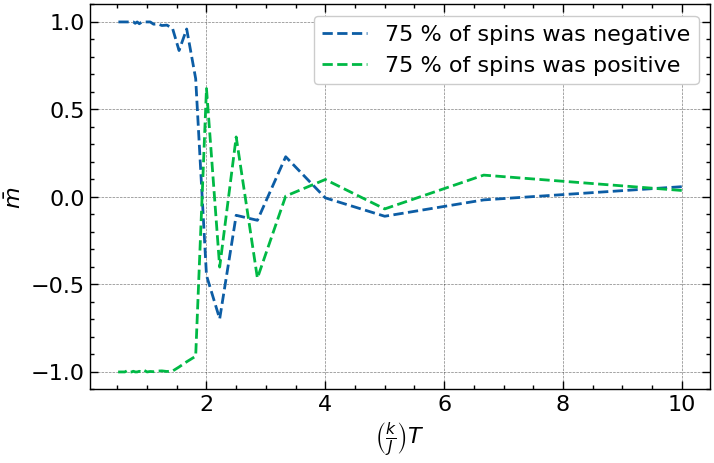

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(1/BJs, ms_n, '--' , label = '75 % of spins was negative')
plt.plot(1/BJs, ms_p, '--' , label = '75 % of spins was positive')
plt.xlabel(r"$\left(\frac{k}{J}\right)T$")
plt.ylabel(r'$\bar{m}$')
plt.legend()

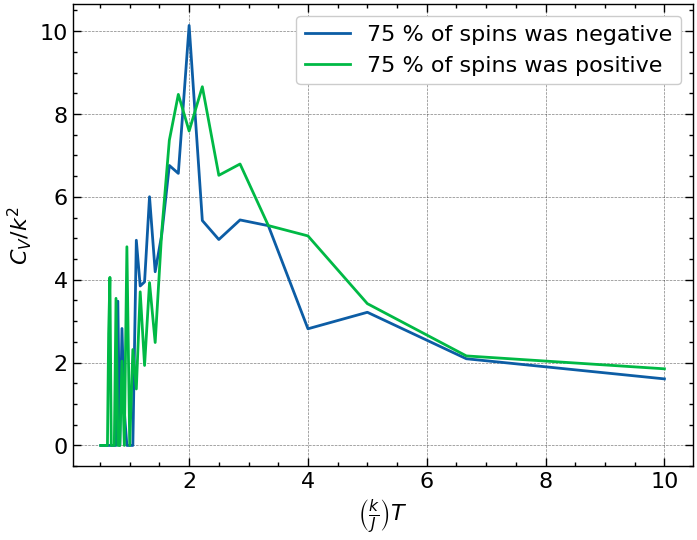

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(1/BJs, E_std_n*BJs, label = '75 % of spins was negative')
plt.plot(1/BJs, E_std_p*BJs, label = '75 % of spins was positive')
plt.xlabel(r"$\left(\frac{k}{J}\right)T$")
plt.ylabel(r'$C_V /k^2$')
plt.legend()